In [15]:
import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word
from lambeq import AtomicType, IQPAnsatz, NumpyModel, QuantumTrainer, SPSAOptimizer, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from matplotlib import rcParams

# 型の定義
n, s = Ty('n'), Ty('s')

# 言語モデルのロード
nlp = spacy.load("ja_ginza")

rcParams['font.family'] = 'Hiragino Sans'  # macOS標準のヒラギノ角ゴ
rcParams['axes.unicode_minus'] = False     # マイナス記号が文字化けしないように

In [ ]:
df = pd.read_csv("/Users/horiuchiminori/Desktop/研究/datasets/日本語4クラス/combined_unique.csv")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])

In [19]:
# -----------------------------
# 1. トークン分割関数
# -----------------------------
def tokenize(text):
    return [t.text for t in nlp(text)]

# -----------------------------
# 2. トレーニングトークン集合を作成
# -----------------------------
train_tokens = set()

for sentence in train_df["text"]:
    for token in tokenize(sentence):
        train_tokens.add(token)

# -----------------------------
# 3. テスト文をフィルタ
# -----------------------------
def test_sentence_is_valid(text):
    tokens = tokenize(text)
    # １つでも train にないトークンがあれば不可
    return all(token in train_tokens for token in tokens)

# -----------------------------
# 4. フィルタ適用
# -----------------------------
test_df_filtered = test_df[test_df["text"].apply(test_sentence_is_valid)].reset_index(drop=True)

In [ ]:
def label_to_onehot(label):
    # 0~3のラベルを2x2ワンホット表現に変換
    mapping = {
        0: np.array([[1, 0],
                     [0, 0]], dtype=object),
        1: np.array([[0, 1],
                     [0, 0]], dtype=object),
        2: np.array([[0, 0],
                     [1, 0]], dtype=object),
        3: np.array([[0, 0],
                     [0, 1]], dtype=object),
    }
    return mapping[int(label)]

    """
    #mapping = {
        0: x = [1, 0, 0, 0],
        1: x = [0, 1, 0, 0],
        2: x = [0, 0, 1, 0],
        3: x = [0, 0, 0, 1],
    }
    """

def make_label_array(df):
    labels = [label_to_onehot(label) for label in df['label']]
    return np.array(labels, dtype=object)

train_labels = make_label_array(train_df)
test_labels = make_label_array(test_df_filtered)

train_sentences = train_df['text']
test_sentences = test_df_filtered['text']

print("train_labels.shape, dtype:", train_labels.shape, train_labels.dtype)

train_labels.shape, dtype: (68, 2, 2) object


In [24]:
train_labels = np.stack([np.array(x, dtype=float) for x in train_labels], axis=0)
test_labels  = np.stack([np.array(x, dtype=float) for x in test_labels], axis=0)

print("train_labels.shape, dtype:", train_labels.shape, train_labels.dtype)

train_labels.shape, dtype: (68, 2, 2) float64


In [25]:
# 型の割り当て
def assign_types(sentence):
    doc = nlp(sentence)
    pregroup_types = {}
    dependencies = []

    # 文末記号を除いてトークン化
    valid_tokens = [t for t in doc if t.text not in ['.', '。', '!', '！', '?', '？']]

    for token in valid_tokens:
        token_key = f"{token.text}_{token.i}"  # ← spaCyの固有インデックスを使用
        head_key = f"{token.head.text}_{token.head.i}" if token.head.text in [t.text for t in valid_tokens] else None

        # 型割り当て
        if token.dep_ == 'ROOT':
            pregroup_types[token_key] = s
        else:
            pregroup_types[token_key] = n

        if head_key:
            dependencies.append((token_key, head_key))

    # 依存関係による型調整
    for dep_from, dep_to in dependencies:
        if dep_from == dep_to or dep_to not in pregroup_types or dep_from not in pregroup_types:
            continue

        idx1 = int(dep_from.split('_')[-1])
        idx2 = int(dep_to.split('_')[-1])

        if idx1 < idx2:
            pregroup_types[dep_to] = n.r @ pregroup_types[dep_to]
        else:
            pregroup_types[dep_to] = pregroup_types[dep_to] @ n.l

    return pregroup_types

# Diagram作成
def create_diagram(sentence):
    pregroup_types = assign_types(sentence)

    words = []
    types = Ty()

    # ここでインデックスを除去して、lambeqが単語単位でパラメータを共有できるようにする
    for word_key, typ in pregroup_types.items():
        base_word = word_key.split('_')[0]  # "book_0" → "book"
        words.append(Word(base_word, typ))
        types @= typ

    # すべてのWordをテンソル積で連結
    diagram = Id().tensor(*words)

    # Cups適用
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1

    return diagram

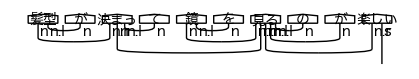

In [26]:
# 各データセットのdiagram化
train_diagrams = []
test_diagrams = []

for i, sentence in enumerate(train_sentences):
    try:
        d = create_diagram(sentence)

        # 出力タイプをチェック
        if hasattr(d, "cod"):  # discopy.Diagram なら cod が出力タイプ
            if d.cod == Ty('s'):
                train_diagrams.append(d)
            else:
                print(f"⚠️ index {i} {d.cod}: {sentence}")
        else:
            print(f"❌ Invalid diagram object at index {i}: {sentence}")

    except Exception as e:
        print(f"\n❌ index {i}: {sentence}\n{e}")


for sentence in test_sentences:
    test_diagrams.append(create_diagram(sentence))

# チェック用for d in range(len(train_sentences)):
    #draw(train_diagrams[d])
train_diagrams[0].draw(figsize=(4, 4))

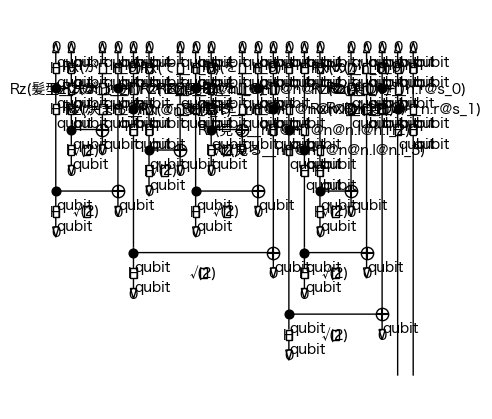

In [27]:
# 量子回路設計
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 2}, n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

# チェック用
train_circuits[0].draw(figsize=(4, 4))

In [10]:
# モデル
from lambeq import NumpyModel
all_circuits = train_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=False)

# 損失関数
from lambeq.training import CELoss4
ce = CELoss4(use_jax=True)

# 目的関数
def acc(y_hat, y):
        ptrue= []
        for s  in range(len(y)):
            s0=y[s,0,0]
            s1=y[s,0,1]
            s2=y[s,1,0]
            s3=y[s,1,1]
            ptrue.append(np.array([s0, s1, s2, s3]))
            
        qtrue=np.array(ptrue)
 
        ppredic= [ ]
        for s in range(len(y_hat)):
            p0=y_hat[s,0,0]
            p1=y_hat[s,0,1]
            p2=y_hat[s,1,0]
            p3=y_hat[s,1,1]
            q0=abs(p0)**2
            q1=abs(p1)**2
            q2=abs(p2)**2
            q3=abs(p3)**2
            qq=q0+q1+q2+q3
            q0n=q0/qq
            q1n=q1/qq
            q2n=q2/qq
            q3n=q3/qq
            ppredic.append(np.array([q0n,q1n,q2n,q3n]))
        
        ppre=np.array(ppredic)
    
        Error=0.0
        
        for s  in range(len(y)):
            p=(ppre[s,0]-qtrue[s,0])**2+(ppre[s,1]-qtrue[s,1])**2+(ppre[s,2]-qtrue[s,2])**2+(ppre[s,3]-qtrue[s,3])**2
            #p=numpy.dot(ppre[s,:], ptrue[s,:])
            Error= Error+p
            Error=Error/len(y)
            AC=1.0-Error

        return AC

In [28]:
# モデル
from lambeq import NumpyModel
all_circuits = train_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=False)

# 損失関数
from lambeq.training import CELoss4
ce = CELoss4(use_jax=True)

def acc(y_hat, y):
    """
    y_hat: 予測出力（batch_size, 2, 2）
    y: 正解ラベル（batch_size, 2, 2）
    """
    # 複素数の絶対値を取る
    y_hat_real = np.abs(y_hat) ** 2 if np.iscomplexobj(y_hat) else y_hat

    # 各サンプルをflattenして比較
    y_hat_flat = y_hat_real.reshape(len(y_hat), -1)
    y_flat = y.reshape(len(y), -1)

    # argmaxを取ってクラス化（4通りのラベル → 0,1,2,3）
    pred_labels = np.argmax(y_hat_flat, axis=1)
    true_labels = np.argmax(y_flat, axis=1)

    # 正解率を計算
    correct = np.sum(pred_labels == true_labels)
    accuracy = correct / len(y)

    return accuracy


In [29]:
# 学習の設定
BATCH_SIZE = 16
LEARNING_RATE = 3e-2
EPOCHS = 10
SEED = 0

trainer = QuantumTrainer(
    model,
    loss_function=ce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=0,
)

from lambeq import Dataset

train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
test_dataset = Dataset(test_circuits, test_labels, shuffle=False)

In [30]:
import numpy as np, time

# 1) diagram とラベルの数
print("train_diagrams:", len(train_diagrams))
print("train_labels:", len(train_labels))
print("test_diagrams:", len(test_diagrams))
print("test_labels:", len(test_labels))

# 2) ラベルの型と中身（先頭3個）
print("train_labels dtype:", train_labels.dtype)
print("sample train_labels[0]:", train_labels[0])

# 3) model の出力の型/shape を簡易確認（少数サンプルで）
sample_out = model(train_circuits[:4])
print("model(train_circuits[:4]) type:", type(sample_out))
try:
    arr = np.array(sample_out)
    print("-> numpy.shape:", arr.shape, "dtype:", arr.dtype)
    print("-> sample element[0]:", arr[0])
except Exception as e:
    print("-> could not convert to np.array:", e)

# 4) forward time check (1 batch)
X = train_circuits[:min(4, len(train_circuits))]
start = time.time()
_ = model(X)
print("forward time for 4 circuits: {:.3f} s".format(time.time() - start))

train_diagrams: 68
train_labels: 68
test_diagrams: 30
test_labels: 30
train_labels dtype: float64
sample train_labels[0]: [[1. 0.]
 [0. 0.]]
model(train_circuits[:4]) type: <class 'numpy.ndarray'>
-> numpy.shape: (4, 2, 2) dtype: float64
-> sample element[0]: [[0.26558941 0.31834333]
 [0.09772393 0.31834333]]
forward time for 4 circuits: 0.073 s


In [31]:
print(max(len(str(c)) for c in train_circuits))
print(min(len(str(c)) for c in train_circuits))
print(sum(len(str(c)) for c in train_circuits)/len(train_circuits))

X = train_circuits[:4]
import time
t = time.time()
model(X)
print("forward time:", time.time() - t)


28006
8504
15862.941176470587
forward time: 0.07214188575744629


Epoch 2:   train/loss: 1.5482   valid/loss: 2.8099   train/time: 4.66s   valid/time: 5.22s   train/acc: 0.3235   valid/acc: 0.2000
Epoch 4:   train/loss: 3.6092   valid/loss: 2.1754   train/time: 5.04s   valid/time: 0.90s   train/acc: 0.1912   valid/acc: 0.3667
Epoch 6:   train/loss: 0.7538   valid/loss: 3.1688   train/time: 5.05s   valid/time: 1.65s   train/acc: 0.2647   valid/acc: 0.3000
Epoch 8:   train/loss: 1.7138   valid/loss: 3.1780   train/time: 5.07s   valid/time: 0.90s   train/acc: 0.2794   valid/acc: 0.2000
Epoch 10:  train/loss: 2.4848   valid/loss: 3.0783   train/time: 5.10s   valid/time: 0.90s   train/acc: 0.3088   valid/acc: 0.2333

Training completed!
train/time: 24.91s   train/time_per_epoch: 2.49s   train/time_per_step: 0.50s   valid/time: 9.57s   valid/time_per_eval: 0.96s


Test accuracy: 0.23333333333333334


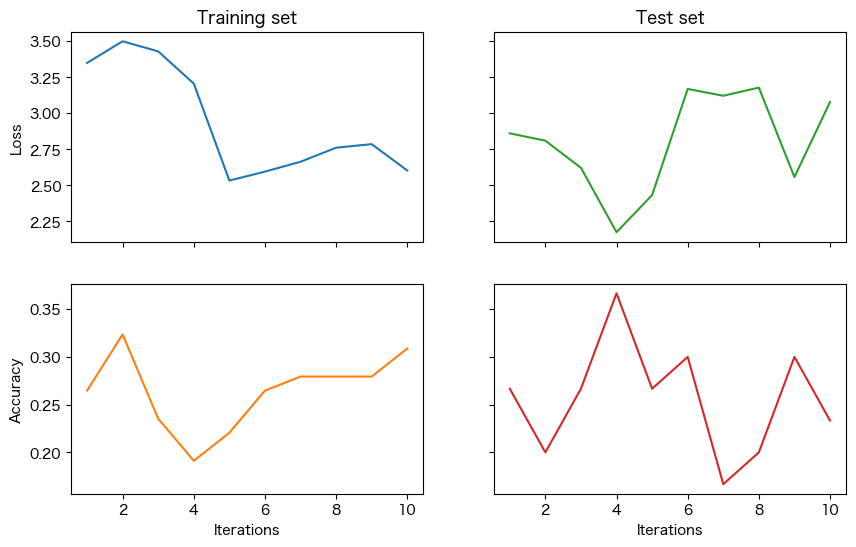

In [32]:
#学習と結果
trainer.fit(train_dataset, test_dataset, log_interval=2)

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Test set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), np.array(test_labels))
print('Test accuracy:', test_acc)